# 1. Intro
This notebook demonstrates the process of gathering local amenity data from OpenStreetMap. Local amenity data of this sort could be used to improve the accuracy of a whole range of ML models. In this notebook, the idea is that that presence of these amenities could help us predict what an AirBnb host might charge.

In this notebook we cover the following:

- How to make basic requests from OpenStreetMap using OSMnx
- How to efficiently calculate the number of amenities that fall within a 5 minute walk of each AirBnb (approximately 0.5km distance).

# 2. Accessing OSM with OSMnx

In [1]:
# Import visualisation modules
import matplotlib as mpl 
%matplotlib inline 
import matplotlib.pyplot as plt 

#Import modules
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np

import warnings 
warnings.simplefilter(action='ignore')

### Basic OSMnx Query
All queries follow the following dictionary format: {'feature_type' : 'feature'}. A full list of OSMnx features can be found [here](https://wiki.openstreetmap.org/wiki/Map_Features). Note, the quality and accuracy of features may vary. OSMnx returns a geopandas dataframe (basically a pandas dataframe with longitude and latitude geometry built into it). It may take a few minutes to download the data.

In [3]:
# Set up query
query = {'amenity':'restaurant'}

# Run query
# restaurants_gdf = ox.pois.pois_from_place(
restaurants_gdf = ox.geometries_from_place(
            'Greater London, UK',
            tags = query,
            which_result=1)

restaurants_gdf.head(5)

amenity                 name  \
element_type osmid                                       
node         451153    restaurant   Central Restaurant   
             26544484  restaurant       Casuarina Tree   
             26604024  restaurant               Jin Li   
             26845558  restaurant  Old Tree Daiwan Bee   
             31098623  restaurant          The Unicorn   

                                        geometry addr:city addr:housename  \
element_type osmid                                                          
node         451153    POINT (-0.19350 51.60203)       NaN            NaN   
             26544484  POINT (-0.17223 51.39801)   Mitcham  The Crown Inn   
             26604024  POINT (-0.45855 51.52573)  Uxbridge            NaN   
             26845558  POINT (-0.13256 51.51105)       NaN            NaN   
             31098623   POINT (0.20053 51.58686)   Romford            NaN   

                      addr:housenumber addr:postcode       addr:street  \
element_type osmid                                                       
node         451153                NaN           NaN               NaN   
             26544484              407       CR4 4BG       London Road   
             26604024               91       UB8 3NJ  Pield Heath Road   
             26845558              NaN           NaN               NaN   
             31098623               91       RM2 5EL         Main Road   

                        cuisine fhrs:authority  ... dinner lunch old_old_name  \
element_type osmid                              ...                             
node         451153         NaN            NaN  ...    NaN   NaN          NaN   
             26544484    indian         Merton  ...    NaN   NaN          NaN   
             26604024   chinese            NaN  ...    NaN   NaN          NaN   
             26845558    taiwan            NaN  ...    NaN   NaN          NaN   
             31098623  american            NaN  ...    NaN   NaN          NaN   

                      terrace note_2 roof:height lgbtq delivery:partner  \
element_type osmid                                                        
node         451153       NaN    NaN         NaN   NaN              NaN   
             26544484     NaN    NaN         NaN   NaN              NaN   
             26604024     NaN    NaN         NaN   NaN              NaN   
             26845558     NaN    NaN         NaN   NaN              NaN   
             31098623     NaN    NaN         NaN   NaN              NaN   

                      amenity2 ways  
element_type osmid                   
node         451153        NaN  NaN  
             26544484      NaN  NaN  
             26604024      NaN  NaN  
             26845558      NaN  NaN  
             31098623      NaN  NaN  

[5 rows x 330 columns]

## Visualise the Results

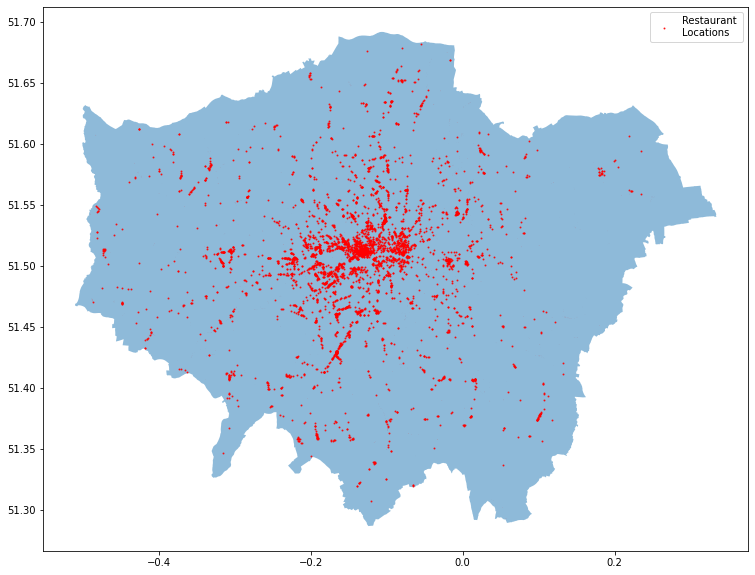

In [4]:
# Download London's Boundary
london_gdf = ox.geocoder.geocode_to_gdf('Greater London, UK')

# Set up a plot axis
fig, ax = plt.subplots(figsize = (15,10))

# Visualise both on the plot
london_gdf.plot(ax = ax, alpha = 0.5)
restaurants_gdf.plot(ax = ax, markersize = 1, color = 'red', alpha = 0.8, label = 'Restaurant \nLocations')
plt.legend()

# Assembling Data

OSMNX returns most restaurant properties as a single point (eg. Longitude / Latitude coordinates). However, a few are returned as polygons (a shape). This usually happens when the property is particularly large. Working with polygons is a lot more complicated than working with points, so below, we will work out the centre point of any polygons. We do this using Spapely.

In [5]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

restaurants_gdf['geometry'] = restaurants_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

### Converting Local Projections
Before we carry out any calculations we need to convert our point coordinates to a local projection. As you know, the earth is a sphere. A projection is a method of flattening the surface of the earth so we can display it on a map. The problem, however, is that there is no way to flatten the surface of a sphere in a way that all parts are sized proportionately equal.

The only way to get around this is to find a projection that makes the specific part of the world that you are interested in proportionately equal. These are called local UTM Coordinate Referencing System (CRS). Fortunately, OSMnx has a method built into it that allows us to find the correct local UTM.

In [6]:
def get_local_crs(y,x):
    x = ox.utils_geo.bbox_from_point((y, x), dist = 500, project_utm = True, return_crs = True)
    return x[-1]

lon_latitude = 51.509865
lon_longitude = -0.118092
local_utm_crs = get_local_crs(lon_latitude, lon_longitude)

local_utm_crs

<Projected CRS: +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next we import our AirBnb room data and convert it into a Geographic dataframe.

In [7]:
# Create a Geographic data of our 
air_df = pd.read_csv('airbnb_rooms.csv')

# Note below: "crs = 4326" is our way of telling geopandas that the initial projection uses the standard
# longitude latitude coordinates. You can't manipulate the CRS if you haven't set one initially.

air_gdf = gpd.GeoDataFrame(air_df, geometry = gpd.points_from_xy(air_df.longitude, air_df.latitude), crs = 4326)
air_gdf = air_gdf.to_crs(local_utm_crs)

#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
restaurants_gdf = restaurants_gdf.to_crs(local_utm_crs)

### Calculating Distance Using a KDTree
So next, we need to iterate through each AirBnb property and work out how many restaurants there are within a 10 minute walk (approximately 1km). 
I do this using a K-D Tree. Explaining how K-D Trees work is outside the scope of this article, but in short, they're a super efficient way of searching through our 80,000 AirBnb rooms and 6,000 restaurants and figuring out which ones are close to which. First we set up the tree of all restaurant points.

In [8]:
import time
from scipy import spatial
from scipy.spatial import KDTree

# Turn long/lats into an array for Scipy
Lon = restaurants_gdf.geometry.apply(lambda x: x.x).values
Lat = restaurants_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations

Then we create a function which we will run on each of our AirBnb rooms. The function will query the tree, and find the 500 closest restaurants along with calculating their distances from the AirBnb property. We use a figure of 500 in the hope that no property has more than 500 restaurants close to it.

In [9]:
def find_points_closeby(lat_lon, k = 500, max_distance = 1000 ):
  '''
  Queries a pre-existing kd tree and returns the number of points within x distance
  of long/lat point.
  lat_lon:        A longitude and latitude pairings in the (y, x) tuple form.
  k:              The maximum number of closest points to query
  max_distance:   The maximum distance (in meters)
  '''
  
  results = tree.query((lat_lon), k = k, distance_upper_bound= max_distance)
  zipped_results = list(zip(results[0], results[1]))
  zipped_results = [i for i in zipped_results if i[0] != np.inf]
  
  return len(zipped_results)

And finally, we set up a timer and apply the function to each AirBnb row

In [10]:
# Set up a timer 
import time 
t0 = time.time()

#Apply the function
air_gdf['restaurants'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

# Report the time
time_passed = round(time.time() - t0, 2)
print ("Completed in %s seconds" % (time_passed))

Completed in 12.22 seconds


You now know how many restaurants there are within a 10-minute walk of each AirBnb property. You could repeat this process for bars, shops, subway stations, tourist hotspots, public parks, and whatever else you think may influence the price of an AirBnb property

In [11]:
air_gdf[['id','restaurants']].head(5)

,id,restaurants
0,13913,47
1,15400,142
2,17402,331
3,25023,2
4,25123,7
